# Code Review I - Different Sigma Scales

This notebook features all of the functions necessary to estimate different length scales. We will look at 2 methods and break this review into two parts:

1. The sigma estimator (scott, silverman, median, mean)
2. The configuration (same length scales, separate length scales, one length scale per dimension)

In [25]:
import sys, os

# Insert path to model directory,.
cwd = os.getcwd()
path = f"{cwd}/../../src"
sys.path.insert(0, path)

import numpy as np
import pandas as pd
from functools import partial

# toy datasets
from data.distribution import DataParams, Inputs

# Plotting Procedures
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use(['seaborn-paper'])

# Insert path to package,.
pysim_path = f"/home/emmanuel/code/pysim/"
sys.path.insert(0, pysim_path)

## Part I - Estimate Sigma

For this first part, we will need to look at how we estimate sigma. I will use the following methods:

* Silverman
* Scot
* Mean
* Median

### Data

For this review, we will be using the distribution loader and we will take the T-Student distribution. We will look at 2 dimensions with 100 samples.

### Helper Functions

* 2D Scatter Plot with Marginal distributions as histograms

In [2]:
def plot_2d_data(X):
    fig  = plt.figure()

    g = sns.jointplot(
        x=X[:, 0],
        y=X[:, 1],
    )
    plt.tight_layout()
    plt.show()
    
def plot_1d_data(X):
    fig, ax = plt.subplots()
    ax.hist(X)
    


We initialize a DataParameters `namedtuple`. It contains all of the parameters we need to generate our dataset. I chose a `namedTuple` because it is immutable so it won't be overwritten once we've called it within our functions. It also has a method to actually provide the data given the parameters, `generate_data`.

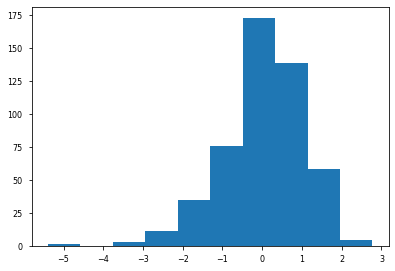

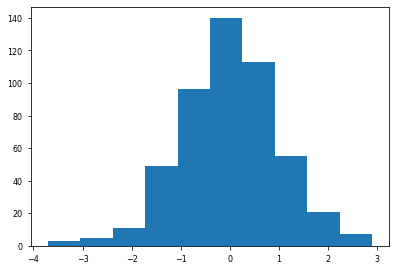

In [3]:
# initialize the data generator
dist_data = DataParams(
    dataset='tstudent',
    trial=1,
    std=2,
    nu=7,
    samples=500,
    dimensions=2
)
inputs = dist_data.generate_data()

# Plot the Distribution
plot_1d_data(inputs.X[:, 0])
plot_1d_data(inputs.X[:, 1])

As we can see, these are clearly two different distributions and we would like to see how the different estimators work.

### Estimator I - Scotts Method

$$
\text{scott} = N^{- \frac{1}{D + 4}}
$$

where $N$ is the number of samples and $D$ is the number of data points.

**Source**:

* [Scipy Website](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gaussian_kde.html)

According to the formula, we aren't actually calculating anything to do with the distance. So we will get the same value for both datasets.

This is easy to calculate in numpy.


In [4]:
def scotts_factor(X: np.ndarray) -> float:
    """Scotts Method to estimate the length scale of the 
    rbf kernel.
    
        factor = n**(-1./(d+4))
    
    Parameters
    ----------
    X : np.ndarry
        Input array
    
    Returns
    -------
    factor : float
        the length scale estimated
    
    """
    n_samples, n_features = X.shape
    
    return np.power(n_samples, - 1 / (n_features + 4.))

In [5]:
sigmas = {}

sigmas['scott'] = (
    scotts_factor(inputs.X[:, 0][:, None]), 
    scotts_factor(inputs.Y[:, 0][:, None])
)

# check same value
assert sigmas['scott'][0] == sigmas['scott'][1]
print(sigmas['scott'])

(0.2885399811814427, 0.2885399811814427)


### Estimator II - Silverman

This is a slight different interpretation but very similar.

$$
\text{silverman} = \left( \frac{N * (D+2)}{4} \right)^{- \frac{1}{D + 4}}
$$

In [6]:
def silvermans_factor(X: np.ndarray) -> float:
    """Silvermans method used to estimate the length scale
    of the rbf kernel.
    
    factor = (n * (d + 2) / 4.)**(-1. / (d + 4)).
    
    Parameters
    ----------
    X : np.ndarray,
        Input array
    
    Returns
    -------
    factor : float
        the length scale estimated
    """
    n_samples, n_features = X.shape
    
    base = ( n_samples * (n_features + 2.) ) / 4.
    
    return np.power(base, - 1 / (n_features + 4.))

In [7]:
sigmas = {}

sigmas['silverman'] = (
    silvermans_factor(inputs.X[:, 0][:, None]), 
    silvermans_factor(inputs.Y[:, 0][:, None])
)

# check same value
assert sigmas['silverman'][0] == sigmas['silverman'][1]

print(sigmas['silverman'])

(0.30562842716315974, 0.30562842716315974)


### Method III - Mean/Median Distance Heuristic

The heuristic is the 'mean distance between the points of the domain'. The full formula is:

$$
\nu = \sqrt{\frac{H_n}{2}}
$$

where $H_n = \text{Med}\left\{ ||X_{n,i} - X_{n,j}||^2 | 1 \leq i < j \leq n \right\}$ and $\text{Med}$ is the empirical median. We can also use the **Mean** as well. We can obtain this by:

1. Calculating the squareform euclidean distance of all points in our dataset
2. Order them in increasing order
3. Set $H_n$ to be the central element if $n(n-1)/2$ is odd or the mean if $n(n-1)/2$ is even.

**Note**: some authors just use $\sqrt{H_n}$.

**Source**: 

* Large Sample Analysis of the Median Heuristic - Garreau et al. (2018) - [PDF](https://arxiv.org/pdf/1707.07269.pdf)
> In particular, look at equation 2. They talk about how to find the heuristic as well as some asymptoptic properties.
* The Mean and Median Criterion for Automatic Kernel Bandwidth Selection for Support Vector Data Description - Chaudhuri et. al. (2017) - [arxiv](https://arxiv.org/pdf/1708.05106.pdf)

In other papers, they have defined others but I have yet to see too many people actually exploring the space of solutions. It's mostly swept under the rug.

For our example, I have done the simple calculation of using squared euclidean distances.

In [8]:
from scipy.spatial.distance import pdist, squareform


0.8120777689523777 0.6372118050351774


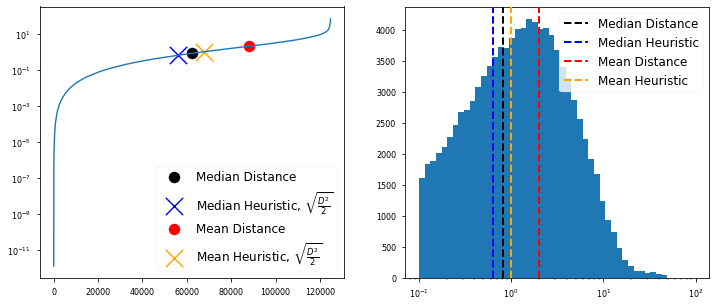

In [9]:
# get the squared euclidean distances
dists = np.sort(pdist(inputs.X[:, 0][:, None], 'sqeuclidean'))
xs = np.linspace(0, 1, len(dists))


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

ax[0].plot(dists)
# ax[0].plot(np.sort(dists.ravel()))
bins = np.logspace(np.log10(1e-1),np.log10(1e2))
ax[1].hist(dists, bins=bins, range=(0, 20))

# ================
# Median Distance
# ================
med_dist = np.median(dists)

# Plot on graph
idx = np.argwhere(dists < med_dist)[-1]
point = dists[dists < med_dist][-1]

ax[0].scatter(idx, point, marker='.', s=500, color='black', label='Median Distance')
ax[1].axvline(med_dist, linewidth=2, zorder=3, color='black', linestyle='dashed', label='Median Distance')

# ================
# Median Heuristic
# ================
heuristic = np.sqrt(med_dist / 2)

idx = np.argwhere(dists < heuristic)[-1]
point = dists[dists < heuristic][-1]

print(med_dist, heuristic)


ax[0].scatter(idx, point, marker='x', s=300, color='blue', label=r'Median Heuristic, $\sqrt{\frac{D^2}{2}}$')
ax[1].axvline(heuristic, linewidth=2, zorder=3, color='blue', linestyle='dashed', label='Median Heuristic')


# ================
# Mean Distance
# ================
mean_dist = np.mean(dists)

# Plot on graph
idx = np.argwhere(dists < mean_dist)[-1]
point = dists[dists < mean_dist][-1]
ax[0].scatter(idx, point, marker='.', s=500, color='red', label='Mean Distance')
ax[1].axvline(mean_dist, linewidth=2, zorder=3, color='red', linestyle='dashed', label='Mean Distance')


# ================
# Mean Heuristic
# ================
heuristic = np.sqrt(mean_dist / 2)

# Plot on graph
idx = np.argwhere(dists < heuristic)[-1]
point = dists[dists < heuristic][-1]
ax[0].scatter(idx, point, marker='x', s=300, color='orange', label=r'Mean Heuristic, $\sqrt{\frac{D^2}{2}}$')
ax[1].axvline(heuristic, linewidth=2, zorder=3, color='orange', linestyle='dashed', label='Mean Heuristic')


ax[0].set_yscale('log')
ax[1].set_xscale('log')
ax[0].legend(fontsize=12)
ax[1].legend(fontsize=12)

### Method III - Inherited Distance Measure

This is a distance measure that is new to me. It is the median/mean of the distances to the $k-th$ neighbour of the dataset. So essentially, we take 

1. Calculate the squareform of the matrix
2. Sort the matrix in ascending order
3. Take the kth distance
4. Take the median or mean of this columns


In [10]:
def kth_distance(dists: np.ndarray, percent: float) -> np.ndarray:
    
    # kth distance calculation (50%)
    kth_sample = int(percent * dists.shape[0])
    
    # take the Kth neighbours of that distance
    k_dist = dists[:, kth_sample]
    
    return k_dist

In [12]:
# get the sorted square form of the squared euclidean distances
dists1 = np.sort(squareform(pdist(inputs.X[:, 0][:, None], 'sqeuclidean')))
dists2 = np.sort(squareform(pdist(inputs.X[:, 1][:, None], 'sqeuclidean')))

# check the shape
assert dists1.shape[0] == inputs.X[:, 0].shape[0]
# np.testing.assert_array_almost_equal(dists, dists2)

# kth distance calculation (50%)
kth_sample = int(0.5 * dists1.shape[0])

# take the Kth neighbour of that distance
k_dist1 = dists1[:, kth_sample]
k_dist2 = dists2[:, kth_sample]

# take the mean or median distance
median_dist1 = np.median(k_dist1)
median_dist2 = np.median(k_dist2)

#### Demo - Different K Distances

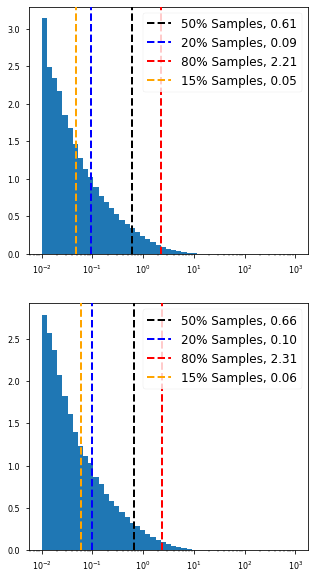

In [14]:

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(5, 10))

# ax[0].plot(np.sort(dists.ravel()))
bins = np.logspace(np.log10(1e-2),np.log10(1e3))
ax[0].hist(dists1.ravel(), bins=bins, density=True)
ax[1].hist(dists2.ravel(), bins=bins, density=True)

# ==============================
# Median Distance (50% Samples)
# ==============================
percent = 0.50
med_dist = np.median(kth_distance(dists1, percent))
label = f"50% Samples, {med_dist:.2f}"
ax[0].axvline(med_dist, linewidth=2, zorder=3, color='black', linestyle='dashed', label=label)

percent = 0.50
med_dist = np.median(kth_distance(dists2, percent))
label = f"50% Samples, {med_dist:.2f}"
ax[1].axvline(med_dist, linewidth=2, zorder=3, color='black', linestyle='dashed', label=label)

# ==============================
# Median Distance (20% Samples)
# ==============================
percent = 0.20
med_dist = np.median(kth_distance(dists1, percent))
label = f"20% Samples, {med_dist:.2f}"
ax[0].axvline(med_dist, linewidth=2, zorder=3, color='blue', linestyle='dashed', label=label)

percent = 0.20
med_dist = np.median(kth_distance(dists2, percent))
label = f"20% Samples, {med_dist:.2f}"
ax[1].axvline(med_dist, linewidth=2, zorder=3, color='blue', linestyle='dashed', label=label)

# ==============================
# Median Distance (80% Samples)
# ==============================
percent = 0.80
med_dist = np.median(kth_distance(dists1, percent))
label = f"80% Samples, {med_dist:.2f}"
ax[0].axvline(med_dist, linewidth=2, zorder=3, color='red', linestyle='dashed', label=label)

percent = 0.80
med_dist = np.median(kth_distance(dists2, percent))
label = f"80% Samples, {med_dist:.2f}"
ax[1].axvline(med_dist, linewidth=2, zorder=3, color='red', linestyle='dashed', label=label)

# ==============================
# Median Distance (15% Samples)
# ==============================
percent = 0.15
med_dist = np.median(kth_distance(dists1, percent))
label = f"15% Samples, {med_dist:.2f}"
ax[0].axvline(med_dist, linewidth=2, zorder=3, color='orange', linestyle='dashed', label=label)

percent = 0.15
med_dist = np.median(kth_distance(dists2, percent))
label = f"15% Samples, {med_dist:.2f}"
ax[1].axvline(med_dist, linewidth=2, zorder=3, color='orange', linestyle='dashed', label=label)


ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[0].legend(fontsize=12)
ax[1].legend(fontsize=12)

## Part II - Different Sigma Configurations

So now, we will look at the different ways we can calculate the sigma values. The options are:

1. 1 Sigma Value for both $\sigma_{XY}$
2. 1 Sigma Value per dataset $\sigma_X, \sigma_Y$
3. 1 Sigma Value per dataset per dimension $\sigma_{X_d}, \sigma_{Y_d}$

In [15]:
def sigma_estimate(X: np.ndarray, method: str='scott'):
    
    if method == 'silverman':
        return silvermans_factor(X)
    elif method == 'scott':
        return scotts_factor(X)
    else:
        raise ValueError(f"Unrecognized distance measure: {method}")

### Data

We will revist the distribution except now we will look at the joint plot.

<Figure size 460.8x316.8 with 0 Axes>

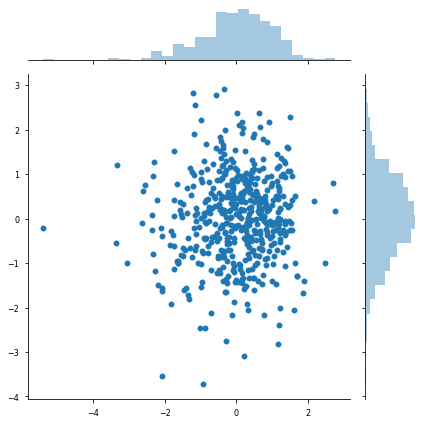

In [16]:
# initialize the data generator
dist_data = DataParams(
    dataset='tstudent',
    trial=1,
    std=2,
    nu=7,
    samples=500,
    dimensions=2
)
inputs = dist_data.generate_data()

# Plot the Distribution
plot_2d_data(inputs.X)


#### Scott n Silverman

In [17]:
# scotts method
sigmas = {}

# 1 sigma per dataset
sigma_x = sigma_estimate(inputs.X, 'scott')
sigma_y = sigma_estimate(inputs.Y, 'scott')
print(f"Sigma Per (X,Y): {sigma_x:.4f},{sigma_y:.4f}")

# 1 sigma for both
sigma_xy = np.mean([sigma_x, sigma_y])
print(f"Sigma Same (XY): {sigma_xy:.4f}")

# 1 sigma per dimensions
sigma_x = [sigma_estimate(ix.reshape(-1,1), 'scott') for ix in inputs.X.T]
sigma_y = [sigma_estimate(iy.reshape(-1,1), 'scott')  for iy in inputs.Y.T]
print(f"Sigma Per Dimension (X,Y):\n{sigma_x},\n{sigma_y}")

Sigma Per (X,Y): 0.3550,0.3550
Sigma Same (XY): 0.3550
Sigma Per Dimension (X,Y):
[0.2885399811814427, 0.2885399811814427],
[0.2885399811814427, 0.2885399811814427]


This makes sense as we get the same $\sigma$ value for both $X,Y$ because they don't take into consideration any aspects of the individual datasets. Only the number of samples and dimensions. There is a difference between per dimension because we have changed the dimension parameter, but there is no difference between datasets.

We expect to see the same thing for silverman

In [18]:
# silvermans method

# 1 sigma per dataset
sigma_x = sigma_estimate(inputs.X, 'silverman')
sigma_y = sigma_estimate(inputs.Y, 'silverman')
print(f"Sigma Per (X,Y): {sigma_x:.4f},{sigma_y:.4f}")

# 1 sigma for both
sigma_xy = np.mean([sigma_x, sigma_y])
print(f"Sigma Same (XY): {sigma_xy:.4f}")

# 1 sigma per dimensions
sigma_x = [sigma_estimate(ix.reshape(-1,1), 'silverman') for ix in inputs.X.T]
sigma_y = [sigma_estimate(iy.reshape(-1,1), 'silverman') for iy in inputs.Y.T]
print(f"Sigma Per Dimension (X,Y):\n{sigma_x},\n{sigma_y}")

Sigma Per (X,Y): 0.3550,0.3550
Sigma Same (XY): 0.3550
Sigma Per Dimension (X,Y):
[0.30562842716315974, 0.30562842716315974],
[0.30562842716315974, 0.30562842716315974]


So the pattern is the same as scott: there are different values if we change the number of input dimensions, but we get the same values across datasets with the same number of samples and dimensions.

**Note**: it looks a little fishy that the $\sigma_{XY}$ is the same for Scott and Silverman. But that's because in 2D, the measures are equivalent because the base factor of $\frac{N(D+2)}{4}$ is equal to $N$ if $D=2$. The exponent is the same for both estimators. Example in 3 dimensions: 

In [19]:
# initialize the data generator
dist_data = DataParams(
    dataset='tstudent',
    trial=1,
    std=2,
    nu=7,
    samples=500,
    dimensions=3
)
temp_input = dist_data.generate_data()

# 1 sigma per dataset
sigma_x = sigma_estimate(temp_input.X, 'scott')
sigma_y = sigma_estimate(temp_input.Y, 'scott')
print(f"Scott - Sigma Per (X,Y): {sigma_x:.4f},{sigma_y:.4f}")

# 1 sigma per dataset
sigma_x = sigma_estimate(temp_input.X, 'silverman')
sigma_y = sigma_estimate(temp_input.Y, 'silverman')
print(f"Silverman - Sigma Per (X,Y): {sigma_x:.4f},{sigma_y:.4f}")

Scott - Sigma Per (X,Y): 0.4116,0.4116
Silverman - Sigma Per (X,Y): 0.3986,0.3986


We see that they are different.

#### Median, Mean Heuristic

So now I'm going to update my function so that we have the option to add the median and mean heuristic.

In [20]:
def sigma_estimate(X: np.ndarray, method: str='median', heuristic: bool=False):
    
    # get the squared euclidean distances
    if method == 'silverman':
        return silvermans_factor(X)
    elif method == 'scott':
        return scotts_factor(X)
    else:
        dists = np.sort(pdist(X, 'sqeuclidean'))
    
    if method == 'median':
        sigma = np.median(dists)
    elif method == 'mean':
        sigma = np.mean(dists)
    else:
        raise ValueError(f"Unrecognized distance measure: {method}")
    
    if heuristic:
        sigma = np.sqrt(sigma / 2)
    return sigma

In [21]:
# 1 sigma per dataset
sigma_x = sigma_estimate(inputs.X, 'mean')
sigma_y = sigma_estimate(inputs.Y, 'mean')
print(f"Sigma Per (X,Y): {sigma_x:.4f},{sigma_y:.4f}")

# 1 sigma for both
sigma_xy = np.mean([sigma_x, sigma_y])
print(f"Sigma Same (XY): {sigma_xy:.4f}")

# 1 sigma per dimensions
sigma_x = [sigma_estimate(ix.reshape(-1,1), 'mean') for ix in inputs.X.T]
sigma_y = [sigma_estimate(iy.reshape(-1,1), 'mean')  for iy in inputs.Y.T]
print(f"Sigma Per Dimension (X,Y):\n{sigma_x},\n{sigma_y}")

Sigma Per (X,Y): 4.0080,4.0080
Sigma Same (XY): 4.0080
Sigma Per Dimension (X,Y):
[2.004008016032065, 2.004008016032064],
[2.0040080160320635, 2.0040080160320644]


In [22]:
# 1 sigma per dataset
sigma_x = sigma_estimate(inputs.X, 'median')
sigma_y = sigma_estimate(inputs.Y, 'median')
print(f"Sigma Per (X,Y): {sigma_x:.4f},{sigma_y:.4f}")

# 1 sigma for both
sigma_xy = np.mean([sigma_x, sigma_y])
print(f"Sigma Same (XY): {sigma_xy:.4f}")

# 1 sigma per dimensions
sigma_x = [sigma_estimate(ix.reshape(-1,1), 'median') for ix in inputs.X.T]
sigma_y = [sigma_estimate(iy.reshape(-1,1), 'median')  for iy in inputs.Y.T]
print(f"Sigma Per Dimension (X,Y):\n{sigma_x},\n{sigma_y}")

Sigma Per (X,Y): 2.5684,2.7045
Sigma Same (XY): 2.6364
Sigma Per Dimension (X,Y):
[0.8120777689523777, 0.854339231759148],
[0.90660872358859, 0.8619837864110205]


So we see that the median distance does distinguish been the dimensions where as the mean does not. So if we want some differences, it might be worth it to go with the median as a heuristic..

#### Median - Kth Distance

In [23]:
from typing import Optional

def sigma_estimate(
    X: np.ndarray, 
    method: str='median', 
    percent: Optional[int]=None, 
    heuristic: bool=False
) -> float:
    
    # get the squared euclidean distances
    if method == 'silverman':
        return silvermans_factor(X)
    elif method == 'scott':
        return scotts_factor(X)
    elif percent is not None:
        kth_sample = int((percent/100) * X.shape[0])
        dists = np.sort(squareform(pdist(X, 'sqeuclidean')))[:, kth_sample]
#         print(dists.shape, dists.min(), dists.max())
    else:
        dists = np.sort(pdist(X, 'sqeuclidean'))
#         print(dists.shape, dists.min(), dists.max())
        
    
    if method == 'median':
        sigma = np.median(dists)
    elif method == 'mean':
        sigma = np.mean(dists)
    else:
        raise ValueError(f"Unrecognized distance measure: {method}")
    
    if heuristic:
        sigma = np.sqrt(sigma / 2)
    return sigma

In [26]:
percentages = [15, 20, 50, 80]
results_df = pd.DataFrame()

for ipercent in percentages:
    
    print(f"{ipercent}% Samples")
    # 1 sigma per dataset
    sigma_x = sigma_estimate(inputs.X, 'mean', ipercent)
    sigma_y = sigma_estimate(inputs.Y, 'mean', ipercent)

    # 1 sigma for both
    sigma_xy = np.mean([sigma_x, sigma_y])

    # 1 sigma per dimensions
    sigma_x_d = [sigma_estimate(ix.reshape(-1,1), 'mean', ipercent) for ix in inputs.X.T]
    sigma_y_d = [sigma_estimate(iy.reshape(-1,1), 'mean', ipercent)  for iy in inputs.Y.T]
    results_df = results_df.append({
        'percent': ipercent,
        'sigma_xy': sigma_xy,
        'sigma_x': sigma_x,
        'sigma_y': sigma_y,
        'sigma_xd': sigma_x_d,
        'sigma_yd': sigma_y_d,
    }, ignore_index=True)

15% Samples
20% Samples
50% Samples
80% Samples


In [27]:
results_df

,percent,sigma_x,sigma_xd,sigma_xy,sigma_y,sigma_yd
0,15.0,1.020389,"[0.24642895567240075, 0.23416783817803644]",1.017655,1.014922,"[0.20299456942386293, 0.24035251603377777]"
1,20.0,1.300021,"[0.3523831447752424, 0.33390768867246945]",1.293269,1.286516,"[0.3235887727904833, 0.3303919311440132]"
2,50.0,3.074741,"[1.2359792869486763, 1.2295046539405399]",3.089403,3.104064,"[1.2550121778882104, 1.2382606065547748]"
3,80.0,6.042370,"[3.1447792239531553, 3.2164324641215707]",6.144976,6.247582,"[3.2078125520953207, 3.147628845075649]"


And again, we get different values of that median estimate based on the 'knn' distance. And it changes depending upon the dimension as well.